In [1]:
import time
startTime = time.time()

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad, dblquad
from scipy.special import ellipe, ellipk
from scipy.interpolate import lagrange, InterpolatedUnivariateSpline
from scipy.signal import savgol_filter

## User input

In [2]:
# Gas:
# Conversion to linear scale was made in the notebook: grav_project/NGC_5005/Gas_from_mass_surface_density.ipynb
raddens = "../data/gasmsd_kpc_linear.txt"      # Gas density with 2 columns, units: KPC, MSUN/PC^2
maxkpc=11
minkpc=.9473
# Parameters
z0 = 0.93

In [3]:
# Gas
tracedgas = np.loadtxt("../NGC_5005/traced_data/ngc5005_gas.txt")
tracedgas_r, tracedgas_v = tracedgas.T
tracedgas_r = tracedgas_r[1:]
tracedgas_v = tracedgas_v[1:]
radii=tracedgas_r

## Density profile, outputs: radii (array), densities (array), rcut (one #), delta (one #)

In [4]:
def DensityProfile(raddens=raddens):
    mudata = np.loadtxt(raddens)     
    xdinp, ydinp = mudata.T
    rcut = xdinp[len(xdinp)-1]               # rcut is the LAST radius value (?)
    delta = rcut - xdinp[len(xdinp)-2]       # difference between the last two radius values
    
    return xdinp, ydinp, rcut, delta

#defining these output values:
# Radius
xdinp = DensityProfile()[0]
# Density
ydinp = DensityProfile()[1]
# Cutoff radius
rcut = DensityProfile()[2]
# Cutoff length
delta = DensityProfile()[3]

## Interpolation

In [5]:
def interpd(x,y):
    #return lagrange(x,y)                # Lagrange interpolation didn't work well so I used Univariate Spline
    return InterpolatedUnivariateSpline(x,y,k=4)
    
# Calculate the density values at the sampling radii
spline_rhor = interpd(xdinp,ydinp)        # define the polynomial that's calculated

radii = np.arange(0.001,11,0.1)                # Sampling radii
## Partial derivative / Smoothing

In [6]:
#radii = np.linspace(0.001,maxkpc,100)                # Sampling radii
#radii = np.arange(minkpc,maxkpc,0.1)                # Sampling radii
print(radii)

# Partial derivative of rho(u,z) with respect to u
# Taking the derivative of the splined polynomial (radius and density values, rho(r) or rho(u))
drho_du = spline_rhor.derivative()

# Evaluating at given radii
drho_du_values = drho_du(radii)

# Smoothing: Savitzky-Golay filter: https://riptutorial.com/scipy/example/15878/using-a-savitzky-golay-filter
drho_du_smooth = savgol_filter(drho_du_values, 11, 5)  # window size 11, polynomial order 6

# Spline the smoothed derivative
spline_drhor = interpd(radii,drho_du_smooth)

[ 0.9464  1.4501  1.9258  2.4017  2.8777  3.3677  3.8435  4.3193  4.7951
  5.5927  6.3905  7.2022  7.9999  8.7837  9.5954 10.3792 11.1908]


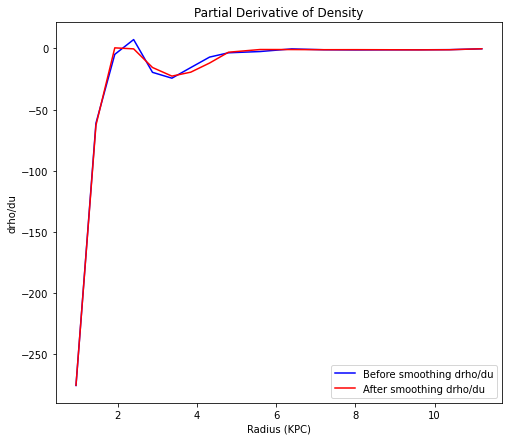

In [7]:
# Plot 
plt.figure(figsize=(8,7))
plt.plot(radii,drho_du_values, label="Before smoothing drho/du", c="blue")
plt.plot(radii,drho_du_smooth, label="After smoothing drho/du", c="red")
#plt.plot(radii,spline_drhor(radii), label="After smoothing and splining drho/du", c="purple")
plt.title("Partial Derivative of Density")
plt.xlabel("Radius (KPC)")
plt.ylabel("drho/du")
plt.legend()
plt.show()

## Functions

In [8]:
#from casertano http://articles.adsabs.harvard.edu/pdf/1983MNRAS.203..735C
# Casertano Eq 2
def drho_du(u,z,z0):
    return spline_drhor(u) * np.cosh(z / z0)**(-2)

print(drho_du(1,1,z0))

-90.77944368790979


In [9]:
# Casertano Eq 5
def px(r,u,z):
    x = (r**2 + u**2 + z**2)/(2*r*u)
    return x - np.sqrt((x**2)-1)

print(px(1,1,1))

0.3819660112501051


In [10]:
# Complete elliptic integral, JUST COPYING FROM THE ROTMOD.C CODE
def fm(r,u,z):
    return 1.0 - px(r,u,z)**2
def e1(r,u,z):
    return ( 1.3862944 + fm(r,u,z) * ( 0.1119723 + fm(r,u,z) * 0.0725296 ) ) - ( 0.5 + fm(r,u,z) * ( 0.1213478 + fm(r,u,z) * 0.0288729 ) ) * np.log( fm(r,u,z) );
def e2(r,u,z):
    return ( 1.0 + fm(r,u,z) * ( 0.4630151 + fm(r,u,z) * 0.1077812 ) ) - ( fm(r,u,z) * ( 0.2452727 + fm(r,u,z) * 0.0412496 ) ) * np.log( fm(r,u,z));
def K_E(r,u,z):
    return e1(r,u,z)- e2(r,u,z)
print(K_E(1,1,1))

0.1214886656384


In [11]:
#constants
G = 0.00000431158                   # Gravitational constant (KPC/MSUN*(KM/S)^2)  

#casertano eq 4, simplified
def integrand(r,u,z,z0,G):
    return (8 * G) * drho_du(u,z,z0) * K_E(r,u,z) / np.sqrt(u * r * px(r,u,z))

print(integrand(1,2,3,z0,G))

2.093076088644507e-08


## Integration

In [12]:
# Define minimum and maximum values of radius for integration
intmin = 0 #0 causes runtime issues but this gets very close
intmax = np.inf #np.max(radii) #Integration is from 0 to infinity but infinity gives overflow errors so we just pick the largest we can without causing errors


0
inf


In [13]:
# Reverse order of variables to setup for integration
integrand2 = lambda u,r,z0,G: u*quad(integrand, intmin, intmax, args=(r,u,z0,G))[0]
print(integrand2(2,1,z0,G))

# Integrate double integral
#radialforce = lambda r: dblquad(integrand2, intmin, intmax, lambda u: intmin, lambda u: intmax, args=(r))
radialforce = lambda r,z0,G: quad(integrand2, intmin, intmax, args=(r,z0,G))[0]
print(radialforce(1,z0,G))
radialforce = np.vectorize(radialforce)
print(radialforce(1,z0,G))

-0.00032796264345610594


<ipython-input-8-6c0664f08d26>:4: RuntimeWarning: overflow encountered in cosh
  return spline_drhor(u) * np.cosh(z / z0)**(-2)
<ipython-input-11-040cb14c4033>:6: RuntimeWarning: invalid value encountered in double_scalars
  return (8 * G) * drho_du(u,z,z0) * K_E(r,u,z) / np.sqrt(u * r * px(r,u,z))
<ipython-input-13-2b6419a21d32>:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrand2 = lambda u,r,z0,G: u*quad(integrand, intmin, intmax, args=(r,u,z0,G))[0]
<ipython-input-13-2b6419a21d32>:7: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the

nan
nan


C:\Users\Loser\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


## Velocity

In [14]:
#casertano eq 6:
velocs = (-radii*radialforce(radii,z0,G))**(0.5)
scale = 5e5
velocs=velocs*scale

<ipython-input-8-6c0664f08d26>:4: RuntimeWarning: overflow encountered in cosh
  return spline_drhor(u) * np.cosh(z / z0)**(-2)
<ipython-input-11-040cb14c4033>:6: RuntimeWarning: invalid value encountered in double_scalars
  return (8 * G) * drho_du(u,z,z0) * K_E(r,u,z) / np.sqrt(u * r * px(r,u,z))
<ipython-input-13-2b6419a21d32>:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrand2 = lambda u,r,z0,G: u*quad(integrand, intmin, intmax, args=(r,u,z0,G))[0]
<ipython-input-13-2b6419a21d32>:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If inc

## Comparison

## More troubleshooting: comparing the F(r) functions

In [15]:
tracedgas_F=tracedgas_v**2/-tracedgas_r


<ipython-input-8-6c0664f08d26>:4: RuntimeWarning: overflow encountered in cosh
  return spline_drhor(u) * np.cosh(z / z0)**(-2)
<ipython-input-11-040cb14c4033>:6: RuntimeWarning: invalid value encountered in double_scalars
  return (8 * G) * drho_du(u,z,z0) * K_E(r,u,z) / np.sqrt(u * r * px(r,u,z))
<ipython-input-13-2b6419a21d32>:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrand2 = lambda u,r,z0,G: u*quad(integrand, intmin, intmax, args=(r,u,z0,G))[0]
<ipython-input-13-2b6419a21d32>:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If inc

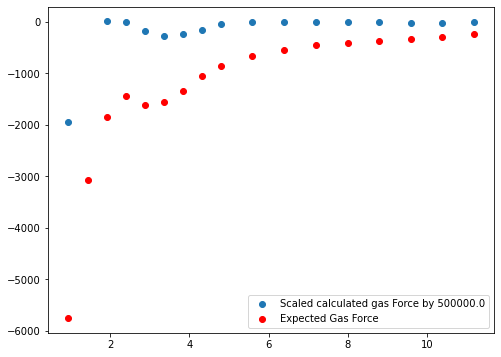

In [16]:
plt.figure(figsize=(8,6))             
plt.scatter(radii,scale*np.asarray(radialforce(radii,z0,G)), linestyle='solid', label='Scaled calculated gas Force by {}'.format(scale))
plt.scatter(tracedgas_r, tracedgas_F, label='Expected Gas Force', c='red')
plt.legend(fontsize=10)

## Plot

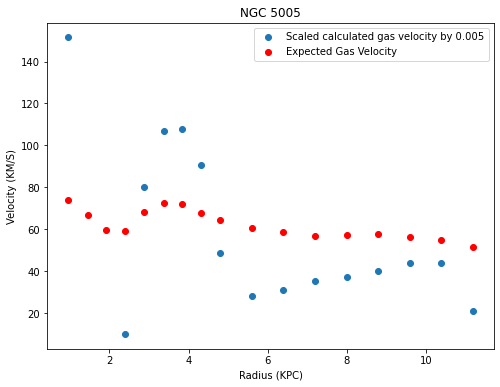

In [17]:
scale=5*.001
plt.figure(figsize=(8,6))             
plt.scatter(radii, scale*np.asarray(velocs), linestyle='solid', label='Scaled calculated gas velocity by {}'.format(scale))
#plt.plot(radii, 1e3*velocs_smooth, linestyle='solid', label='Smoothed Gas Velocity')
plt.scatter(tracedgas_r, tracedgas_v, label='Expected Gas Velocity', c='red')
plt.axis('tight');
plt.title('NGC 5005')
plt.xlabel('Radius (KPC)', fontsize=10)
plt.ylabel('Velocity (KM/S)', fontsize=10)
plt.legend(fontsize=10)
#plt.xlim(0,12)
plt.show()

In [18]:

executionTime = (time.time() - startTime)
print('Execution time in minutes: ' + str(executionTime/60))

Execution time in minutes: 0.8568068544069926
